In [1]:
from ngsolve import *
from ngsolve.webgui import Draw as DrawGeo
import numpy as np
from dispersion import *
import matplotlib.pyplot as plt
from netgen.occ import *
from ipywidgets  import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

%matplotlib inline

We want to calculate the transversal magnetic (TM) modes for a photonic crystal with a YIG rod in the middle along the boundary of the irreducible Brillouine zone $\Gamma-X-M$. Therefore we solve the weak eigenvalue problem

$$
 a_{k}(u,v) = \left(\frac{\omega}{c}\right)^2 b(u,v)  \quad \forall v \in \mathcal{H}_p^1(\Omega)
$$

with 
$$
 a_{k}(u,v) = \int_\Omega {\underline{\mu}}^{-1} \left(\nabla u (r) + i k u( r)\right) \cdot \overline{\left(\nabla v (r) + i k v(r)\right)} \text{dr}\\
 b(u,v) = \int_\Omega \varepsilon \, u(r)\overline{v(r)} \text{dr} \\
 \underline{\mu} = \begin{pmatrix}\mu & -i\kappa \\\ i\kappa & \mu \end{pmatrix}
$$

for wave vectors $k$ in the boundary of the reduced Brillouine zone.

We draw the geometry, set the permittivity $\varepsilon$ and the parameters $\mu, \kappa$ for the permeability tensor. The parameters $\mu$ and $\kappa$ depend on the frequency [GHz] and field strength [T] of the magnetic field. 

In [2]:
a = 1
r = 0.11*a
air = WorkPlane().RectangleC(a,a).Face()
rod = WorkPlane().Circle(0,0,r).Face()
mesh = CreateGeometry(air, rod, max_h = 0.1)
mu, kappa = Permeability(freq=4.28, h0=0.16) # different example h0 = 6
eps = 15
nbands = 4
nparam = 500
dispGEP = DispersionGEP(mesh, mu, kappa, eps)

WebGuiWidget(value={'gui_settings': {}, 'ngsolve_version': '6.2.2302-145-g71ae8afa4', 'mesh_dim': 2, 'order2d'…

Using  a greedy algorithm we build a reduced basis space and calculate the band structure for `n_bands` bands. Subsequently we plot the band structure and the residual. The snapshots are red dots in the band structure. 

RB space of dimension 24 built in 5.100 seconds
online time: 2.558 seconds
min residual: 6.64e-10, mean residual: 2.15e-03, max residual: 6.80e-03
degrees of freedom FEM space:  576


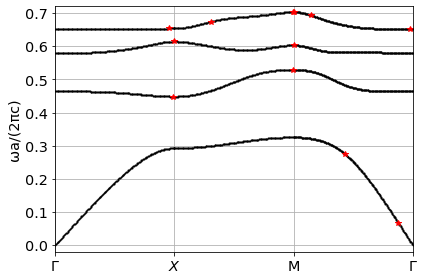

In [4]:
dispGEP.CalculateBandStructure(nbands, th_res=1e-2, nparam=nparam);
print("degrees of freedom FEM space: ", dispGEP.fes.ndof)

Solve problem in real time for reduced basis system for band `band` and zone `zone` and plot the eigenfunction $u$. 

In [5]:
band = 3 # can be 0,..,n_bands
nval = 300 #number of values in band per zone

# define k-values
k_vals = []
for kx in np.linspace(0, np.pi, nval):
    k_vals += [(kx, 0.)]
for ky in np.linspace(0, np.pi, nval):
    k_vals += [(np.pi, ky)]
for kxy in np.linspace(0, np.pi, round(nval*sqrt(2)))[::-1]:
    k_vals += [(kxy, kxy)]

gfu = GridFunction(dispGEP.fes)
draw_obj = DrawGeo(gfu, autoscale=False, eval='norm', min=-0.15, max = 0.15, deformation=True, settings={"edges":False})
def draw(l):
    j = int(l)
    # online calculation
    val = dispGEP.CalculateValues([k_vals[j]], nbands=band+1, calculate_residual=True)
    # recover big vector for post processing
    gfu.vec.data = (dispGEP.Qred*Vector(val['ev'][0][band])).Evaluate()
    # print and update draw object
    print("(kx, ky) = ({:.2f},{:.2f}), residual: {:.2e}".format(k_vals[j][0], k_vals[j][1], val['res'][0][band]), end='\r')
    draw_obj.Redraw()

# define slider
interact(draw, l=widgets.FloatSlider(min=0, max=len(k_vals)-1, step=1, value=0));

WebGuiWidget(value={'gui_settings': {'edges': False}, 'ngsolve_version': '6.2.2302-145-g71ae8afa4', 'mesh_dim'…

interactive(children=(FloatSlider(value=0.0, description='l', max=1023.0, step=1.0), Output()), _dom_classes=(…

Calculate the Chern number for each band.

In [6]:
dispGEP.ChernNumber_FPC(nbands=nbands, ngrid=4); # 16 values
dispGEP.ChernNumber_WLA(nbands=nbands, nzones=7, nval_per_zone=3); # 21 values

FPC: Chern numbers [0, 1, -2, -1], calculated in 0.162 seconds
WLA: Chern numbers [0, 1, -2, -1], calculated in 0.057 seconds


FPC: Chern numbers [0, 1, -2, -1], calculated in 9.465 seconds


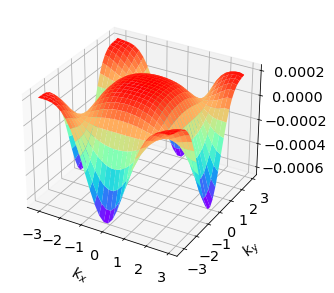

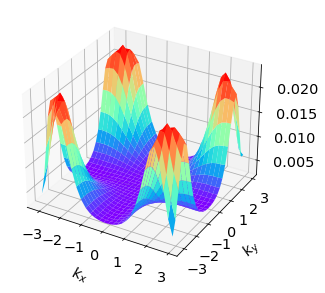

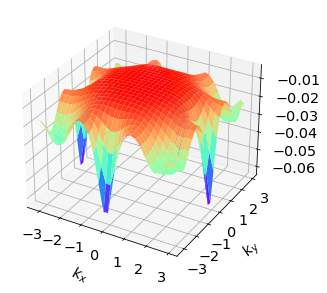

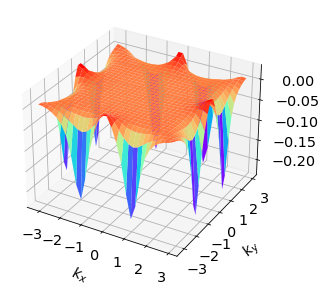

In [9]:
dispGEP.ChernNumber_FPC(nbands=nbands, ngrid=30, plot = True);

WLA: Chern numbers [0, 1, -2, -1], calculated in 0.852 seconds


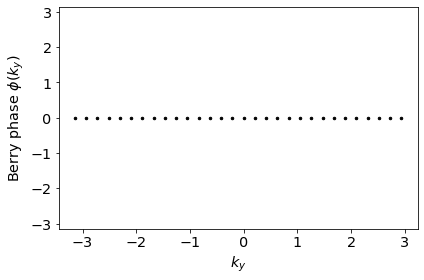

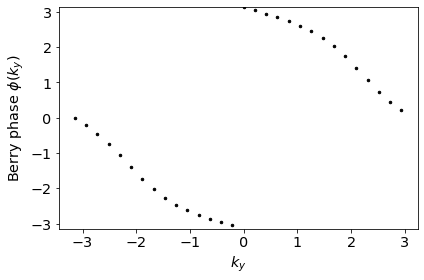

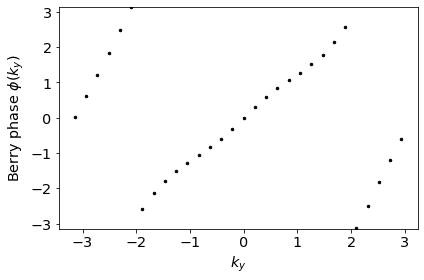

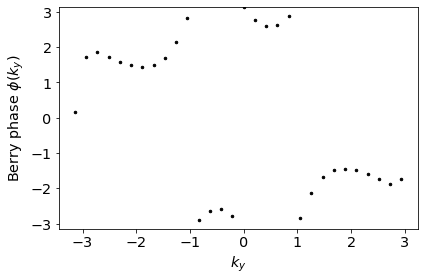

In [7]:
dispGEP.ChernNumber_WLA( nbands=nbands, nzones=30, nval_per_zone=5, plot = True);

calculation time: 30.827 seconds
min residual: 4.36e-16, mean residual: 1.66e-10, max residual: 5.37e-08


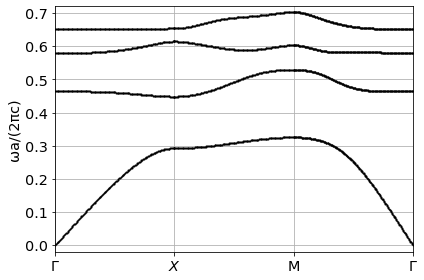

In [8]:
dispGEP.CalculateBandStructure(nbands=nbands, useRB=False, nparam=nparam);